# Multivariate Bijections
## Background
The fundamental idea of normalizing flows also applies to multivariate random variables, and this is where its value is clearly seen - *representing complex high-dimensional distributions*. In this case, a simple multivariate source of noise, for example a standard i.i.d. normal distribution, $X\sim\mathcal{N}(\mathbf{0},I_{D\times D})$, is passed through a vector-valued bijection, $g:\mathbb{R}^D\rightarrow\mathbb{R}^D$, to produce the more complex transformed variable $Y=g(X)$.

Sampling $Y$ is again trivial and involves evaluation of the forward pass of $g$. We can score $Y$ using the multivariate substitution rule of integral calculus,

$$
\begin{aligned}
     \mathbb{E}_{p_X(\cdot)}\left[f(X)\right] &= \int_{\text{supp}(X)}f(\mathbf{x})p_X(\mathbf{x})d\mathbf{x}\\
     &= \int_{\text{supp}(Y)}f(g^{-1}(\mathbf{y}))p_X(g^{-1}(\mathbf{y}))\det\left|\frac{d\mathbf{x}}{d\mathbf{y}}\right|d\mathbf{y}\\
     &= \mathbb{E}_{p_Y(\cdot)}\left[f(g^{-1}(Y))\right],
 \end{aligned}
$$

where $d\mathbf{x}/d\mathbf{y}$ denotes the Jacobian matrix of $g^{-1}(\mathbf{y})$. Equating the last two lines we get,

$$
\begin{aligned}
     \log(p_Y(y)) &= \log(p_X(g^{-1}(y)))+\log\left(\det\left|\frac{d\mathbf{x}}{d\mathbf{y}}\right|\right)\\
     &= \log(p_X(g^{-1}(y)))-\log\left(\det\left|\frac{d\mathbf{y}}{d\mathbf{x}}\right|\right).
\end{aligned}
$$

Inituitively, this equation says that the density of $Y$ is equal to the density at the corresponding point in $X$ plus a term that corrects for the warp in volume around an infinitesimally small volume around $Y$ caused by the transformation. For instance, in $2$-dimensions, the geometric interpretation of the absolute value of the determinant of a Jacobian is that it represents the area of a parallelogram with edges defined by the columns of the Jacobian. In $n$-dimensions, the geometric interpretation of the absolute value of the determinant Jacobian is that is represents the hyper-volume of a parallelepiped with $n$ edges defined by the columns of the Jacobian (see a calculus reference such as [Stewart, 2015](https://www.amazon.com/gp/product/B00YHKU50E) for more details).

Similar to the univariate case, we can compose such bijective transformations to produce even more complex distributions. By an inductive argument, if we have $L$ transforms $g_{(0)}, g_{(1)},\ldots,g_{(L-1)}$, then the log-density of the transformed variable $Y=(g_{(0)}\circ g_{(1)}\circ\cdots\circ g_{(L-1)})(X)$ is

$$
\begin{aligned}
     \log(p_Y(y)) &= \log\left(p_X\left(\left(g_{(L-1)}^{-1}\circ\cdots\circ g_{(0)}^{-1}\right)\left(y\right)\right)\right)+\sum^{L-1}_{l=0}\log\left(\left|\frac{dg^{-1}_{(l)}(y_{(l)})}{dy'}\right|\right),
\end{aligned}
$$

where we've defined $y_{(0)}=x$, $y_{(L-1)}=y$ for convenience of notation.

The main challenge is in designing parametrizable multivariate bijections that have closed form expressions for both $g$ and $g^{-1}$, a tractable Jacobian whose calculation scales with $O(D)$ or $O(1)$ rather than $O(D^3)$, and can express a flexible class of functions.

## Multivariate `Bijector`s
In this section, we show how to use [`B.SplineAutoregressive`](https://flowtorch.ai/api/flowtorch.bijectors.splineautoregressive) to learn the bivariate toy distribution from our running example. Making a simple change we can represent bivariate distributions of the form, $p(x_1,x_2)=p(x_1)p(x_2|x_1)$:

In [1]:
import flowtorch.bijectors as B
import flowtorch.distributions as D
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from sklearn import datasets
from sklearn.preprocessing import StandardScaler

dist_x = torch.distributions.Independent(
  torch.distributions.Normal(torch.zeros(2), torch.ones(2)), 
  1
)
bijector = B.SplineAutoregressive()
dist_y = D.Flow(dist_x, bijector)

The [`bij.SplineAutoregressive`](https://flowtorch.ai/api/flowtorch.bijectors.splineautoregressive) bijector extends [`bij.Spline`](https://flowtorch.ai/api/flowtorch.bijectors.spline) so that the spline parameters are the output of an autoregressive neural network. See [[durkan2019neural]](https://flowtorch.ai/dev/bibliography#durkan2019neural) and [[germain2015made]](/dev/bibliography#germain2015made) for more details.

Similarly to before, we train this distribution on the toy dataset:

In [3]:
n_samples = 1000
X, y = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
X = torch.Tensor(StandardScaler().fit_transform(X))

optimizer = torch.optim.Adam(dist_y.parameters(), lr=5e-3)
for step in range(5001):
    optimizer.zero_grad()
    loss = -dist_y.log_prob(X).mean()
    loss.backward()
    optimizer.step()
    
    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 2.8031821250915527
step: 500, loss: -31.47930335998535


KeyboardInterrupt: 

Plotting the joint distribution:

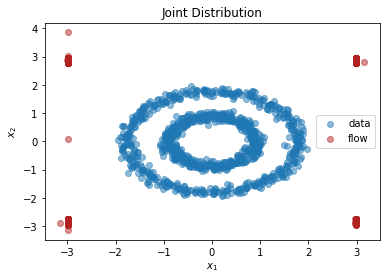

In [4]:
X_flow = dist_y.sample(torch.Size([1000,])).detach().numpy()
plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5)
plt.legend()
plt.show()

And marginals:

C:\Users\info\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\info\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\info\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot

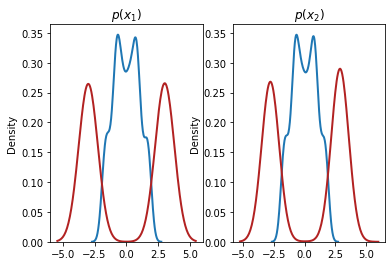

In [5]:
plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True, 
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,0], hist=False, kde=True, 
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True, 
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,1], hist=False, kde=True, 
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_2)$')
plt.show()

We see from the output that, unlike the previous tutorial, this normalizing flow has successfully learnt both the univariate marginals *and* the bivariate distribution.